In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from typing import Dict, Tuple
from IPython.display import display
from matplotlib import pyplot as plt

# Package dependencies:
# https://github.com/anabugaenko/liquidity
# https://github.com/anabugaenko/market_impact

from liquidity.features import compute_returns
from market_impact.response_functions import aggregate_impact
from market_impact.fit import fit_scaling_form, fit_scaling_law 
from market_impact.fss import find_shape_parameters, find_scale_factors, transform
from market_impact.util.data_utils import normalize_imbalances, bin_data_into_quantiles, smooth_outliers, plot_scaling_form, plot_scaling_law

# Nonlinear cross-impact analysis 

See:

Benzaquen, M., Mastromatteo, I., Eisler, Z. and Bouchaud, J.P., 2017. </br>
Dissecting cross-impact on stock markets: An empirical analysis.</br>
Journal of Statistical Mechanics: Theory and Experiment, 2017(2), p.023406.</br>

Patzelt, F. and Bouchaud, J.P., 2018. Universal scaling and nonlinearity of </br>
aggregate price impact in financial markets. Physical Review E, 97(1), p.012304.</br>

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [3]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL', 'GOOG']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_data = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2019-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_data[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_data['TSLA']
amzn_raw_df = stock_data['AMZN']
nflx_raw_df = stock_data['NFLX']
msft_raw_df = stock_data['MSFT']
ebay_raw_df = stock_data['EBAY']
appl_raw_df = stock_data['AAPL']
goog_raw_df = stock_data['GOOG']

In [4]:
tsla_raw_df.head()

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2019-01-02 10:30:07.824615213,1,ASK,REMOVE,True,304.41,3,304.41,304.28,...,166.64482,0.035,0.035,0.13,2019-01-02,0.027172,1241450,13244,0.018002,3
1,1,2019-01-02 10:30:08.674350300,1,ASK,UPDATE,True,304.48,90,304.48,304.28,...,166.64482,0.005,0.005,0.20,2019-01-02,0.027172,1241450,13244,0.540071,90
2,2,2019-01-02 10:30:08.674369576,1,ASK,UPDATE,True,304.49,180,304.49,304.28,...,166.64482,0.005,0.005,0.21,2019-01-02,0.027172,1241450,13244,1.080142,180
3,3,2019-01-02 10:30:08.674371831,1,ASK,UPDATE,True,304.50,109,304.50,304.28,...,166.64482,0.000,0.000,0.22,2019-01-02,0.027172,1241450,13244,0.654086,109
4,4,2019-01-02 10:30:08.674375645,1,ASK,REMOVE,True,304.50,30,304.50,304.28,...,166.64482,0.035,0.035,0.22,2019-01-02,0.027172,1241450,13244,0.180024,30


In [5]:
# Constants 
BINNING_FREQUENCIES = list(range(10, 601))
OBSERVATION_WINDOWS = [10, 20, 50, 100, 150, 300]

## Downsample data
The raw series of different assets have different lengths because the number of orders varies each day. To estimate correlations, all timeseries need to be resampled/reindexed to a common index - e.g., one minutely aggregations, daily or other.

In [6]:
def downsample_tick_data(orderbook_data_input: pd.DataFrame, bin_size: int, unit: str) -> pd.DataFrame:
    """
    Downsamples a dataframe of orderbook data (such as timeseries of orders of certain type)
    according to the frequency specified as input parameter.

    Ensures timeseries are normalised.

    Returns downsampled DataFrame with only columns for which aggregation rule is specified.
    """
    orderbook_data = orderbook_data_input.copy()

    # dictates how orderbook features are aggregated for normalisation across time
    agg_how = {
        "R1": "mean",
        "size": "mean",
        "midprice": "mean",
        "midprice_change": "mean",
        "spread": "mean",
        "signed_volume": "sum",
        "sign": "sum",
        # need for normalisation
        "daily_R1": "mean",
        "daily_vol": "mean",
        "daily_num": "mean",

    }

    # to use pandas `resample` method need to ensure datetime index
    orderbook_data['event_timestamp'] = pd.to_datetime(orderbook_data['event_timestamp'])
    orderbook_data.set_index('event_timestamp', inplace=True)

    # resample and aggregate
    downsampled_df = orderbook_data.resample(f"{bin_size}{unit}").agg(agg_how)

    # rename columns to imbalance after aggregation
    downsampled_df = downsampled_df.rename(columns={
        "signed_volume": "volume_imbalance",
        "sign": "sign_imbalance",
    })

    # adding frequency info explicitly to data
    # T column is assumed when adding price response
    downsampled_df["T"] = bin_size
    downsampled_df["T_unit"] = unit

    return downsampled_df.reset_index()

### Pick sample lag of 600 seconds and inspect correlation

In [7]:
# Set the bin size to second intervals 
downsampled_data = {}
for stock_name, stock_df in stock_data.items():
    downsampled_data[stock_name] = downsample_tick_data(stock_df, bin_size=600, unit="s")

In [8]:
downsampled_data["AAPL"].head()

,event_timestamp,R1,size,midprice,midprice_change,spread,volume_imbalance,sign_imbalance,daily_R1,daily_vol,daily_num,T,T_unit
0,2019-01-02 10:30:00,0.006954,142.397900,155.731453,0.000245,0.018985,-2691,-7,0.006421,2856375.0,20328.0,600,s
1,2019-01-02 10:40:00,0.006419,154.548649,156.530279,0.000581,0.019153,1433,12,0.006421,2856375.0,20328.0,600,s
2,2019-01-02 10:50:00,0.006579,142.773663,156.905802,0.000273,0.019856,762,-14,0.006421,2856375.0,20328.0,600,s
3,2019-01-02 11:00:00,0.006553,147.226316,157.159763,0.000679,0.017695,15063,74,0.006421,2856375.0,20328.0,600,s
4,2019-01-02 11:10:00,0.005682,129.508526,157.663696,0.000597,0.019047,23044,143,0.006421,2856375.0,20328.0,600,s


## Empirical data analysis
### Cross correlation

In [9]:
def display_corr(df:pd.DataFrame, title:str=None, figsize=None, stack=False):
    """
    Helper function to plot dataframe column wise correlation
    using seaborn heatmap with correlation values displayed inside.
    
    Optionally one can provide title to heatmap plot.
    
    Does not return anything
    """
    
    linear_corr = df.corr(method='pearson')
    non_linear_corr = df.corr(method='kendall')
    
    # organise layout - either side by side or stacked
    if not stack:
        num_col = 2
        num_row = 1
    else:
        num_col = 1
        num_row = 2
    
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(12, 5))
    
    # Anchor colormap
    vmin = 0
    vmax = 1
    
    # plot correlations in heatmaps
    plt.subplot(num_row, num_col, 1)
    sns.heatmap(linear_corr, annot=True, fmt='.2f',vmin=-vmin, vmax=vmax)
    plt.title("Linear Correlation (Pearson)")
    
    plt.subplot(num_row, num_col, 2)
    sns.heatmap(non_linear_corr, annot=True, fmt='.2f',vmin=-vmin, vmax=vmax)
    plt.title("Non-linear Correlation (Kendall)")
    
    if title:
        plt.suptitle(title)
        
    return

In [10]:
def compute_correlations(df1: pd.DataFrame, df2: pd.DataFrame, method:str = "kendall") -> Dict[Tuple, float]:
    """
    Helper function to compute correlation betweeb all permutation of 
    columns between two input DataFrames.
    
    Returns a dictionary where keys are tuples of stock names
    for which the correlation is computed and stored as dict value.
    """
    
    correlations = {}
    for col1, col2 in product(df1.columns, df2.columns):
        correlation = df1[col1].corr(df2[col2], method=method)
        correlations[(col1, col2)] = correlation
    return correlations

In [11]:
def display_crosscorrelation(df1: pd.DataFrame, df2: pd.DataFrame, title:str = None, figsize=None,
                         x_label=None, y_label=None):
    """
    Computes and displays linear and non linear (Kendall or spearman method) correlation between
    permutations of columns in the first and second input Dataframes.
    """
    
    # Compute the correlations
    linear_correlations = compute_correlations(df1, df2, method="pearson")
    non_linear_correlations = compute_correlations(df1, df2, method="kendall")
    
    def _plot_corrs(correlations):
        """
        Helper function to transform correlations data and
        display as seaborn heatmap.
        """
        
        # Convert the dictionary to a DataFrame for plotting
        corr_matrix = pd.DataFrame(correlations, index=[0]).T
        corr_matrix.columns = ['Correlation']
        
        # Anchor colormap
        vmin = 0
        vmax = 1

        # Plotting the heatmap
        sns.heatmap(corr_matrix.pivot_table(index=corr_matrix.index.get_level_values(0), 
                                            columns=corr_matrix.index.get_level_values(1), 
                                            values='Correlation'), 
                    annot=True, vmin=-vmin, vmax=vmax)
        
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    _plot_corrs(linear_correlations)
    plt.title("Linear Correlation (Pearson)")
    
    if x_label:
        plt.xlabel(x_label)
        
    if y_label:
        plt.ylabel(y_label)
    
    plt.subplot(1, 2, 2)
    _plot_corrs(non_linear_correlations)
    plt.title("Non-linear Correlation (Kendall)")
    
    if x_label:
        plt.xlabel(x_label)
        
    if y_label:
        plt.ylabel(y_label)
    
    if title:
        plt.suptitle(title)

### Returns (price change) covariance matrix 

We note that .corr appears to increase with larger range of binning frequencies, and pearson returns higher values than kendall in general.

In [12]:
returns_data = {}
price_change_data = {}
for stock_name, data in downsampled_data.items():
    # Compute fractional returns
    data["returns"] = data["midprice"].diff()
    returns_data[stock_name] = data["returns"]
    
# Convert dictionary into DataFrame 
returns_data_df = pd.DataFrame.from_dict(returns_data).dropna()

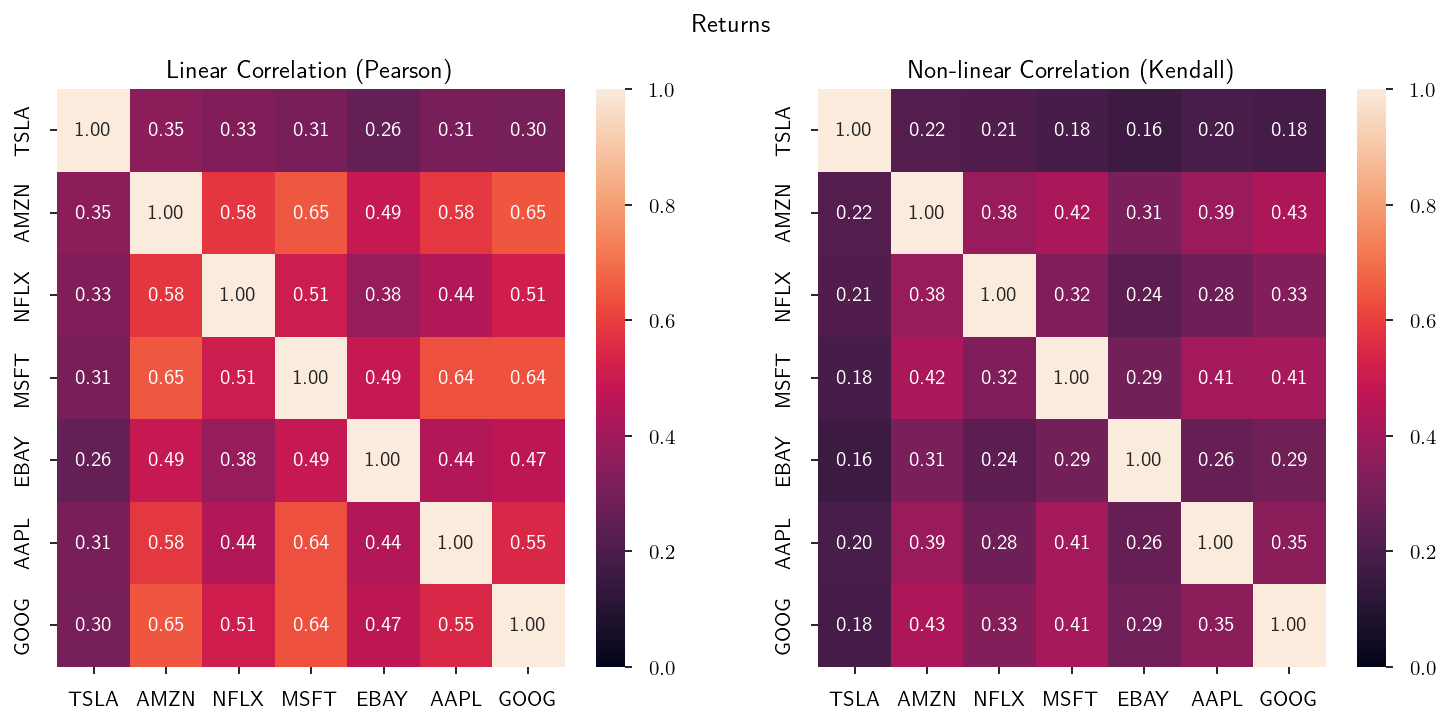

In [13]:
display_corr(returns_data_df, "Returns")

### Lagged covariance of sign (imbalances) matrix
Correlation between sign imbalance of one stock at t+TAU and sign imbalance of another stock at t. shift(1) gets to the t+TAU where TAU is 600 seconds (bin size) in our case. The sign imbalance appear to be independent, but .corr increases with binning frequencies.

In [14]:
sign_imbalance_data = pd.concat([x["sign_imbalance"] for x in downsampled_data.values()], axis=1)
sign_imbalance_data = sign_imbalance_data.dropna()
sign_imbalance_data.columns = downsampled_data.keys()

In [15]:
df_shifted = sign_imbalance_data.shift()
df = sign_imbalance_data

df_shifted = df_shifted.rename(
    columns={stock_name: f"{stock_name}_t_tau" for stock_name in df_shifted.columns}
)
df = df.rename(
    columns={stock_name: f"{stock_name}_t" for stock_name in df.columns}
)

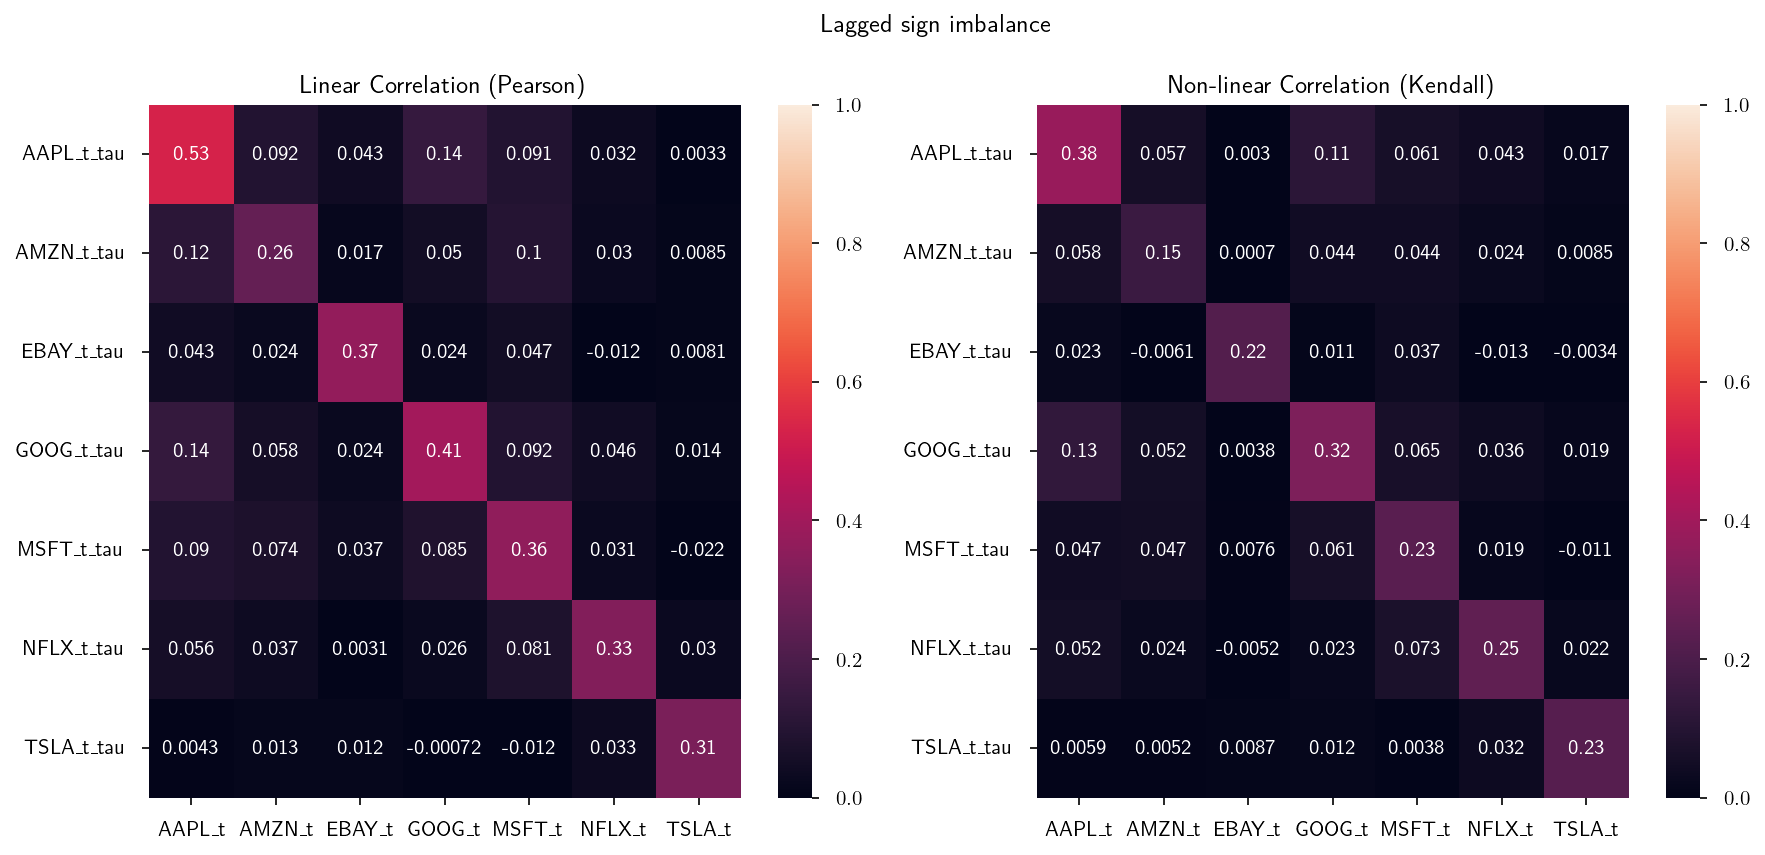

In [16]:
display_crosscorrelation(df_shifted, df, figsize=(14, 6), title="Lagged sign imbalance")

### Equal-time sign (imbalance) process covariance 

In [17]:
sign_process = sign_imbalance_data.diff().dropna()

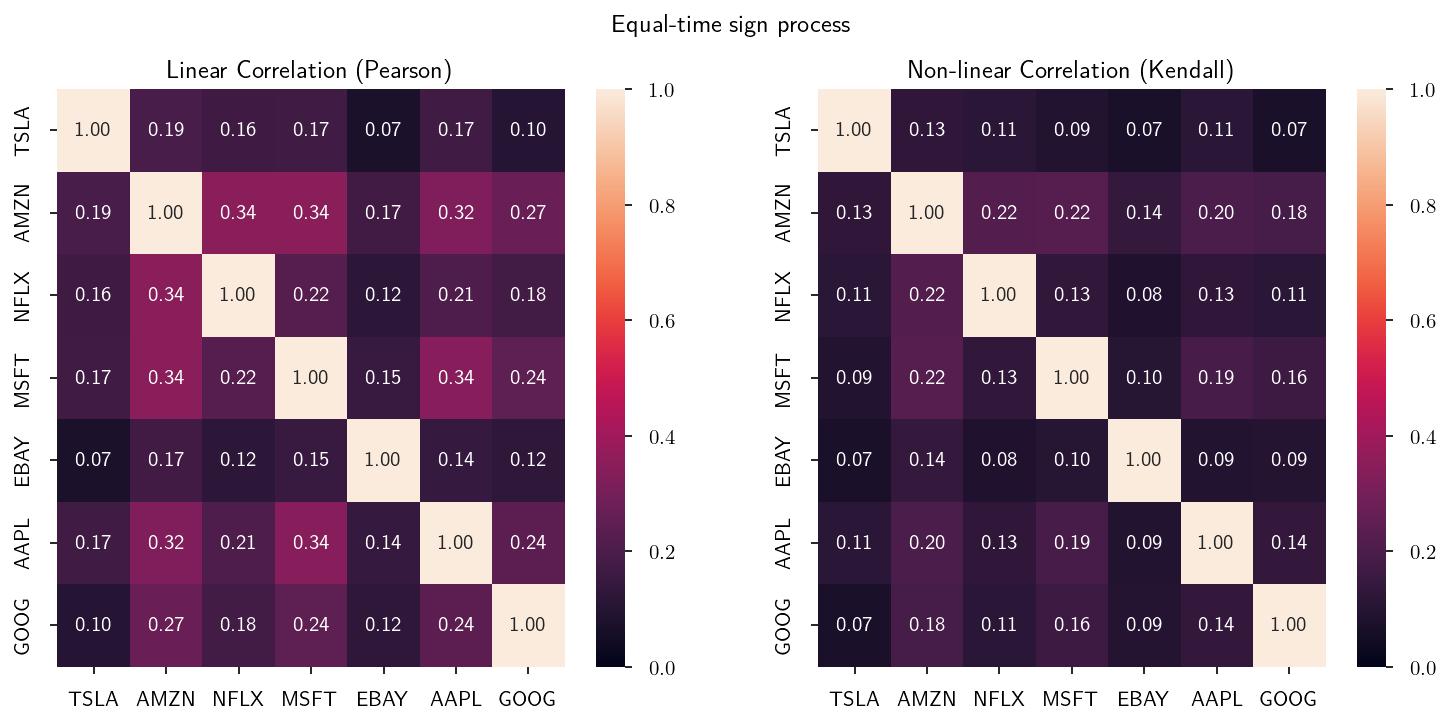

In [18]:
display_corr(sign_process, "Equal-time sign process")

### Same lag sign imbalance correlation

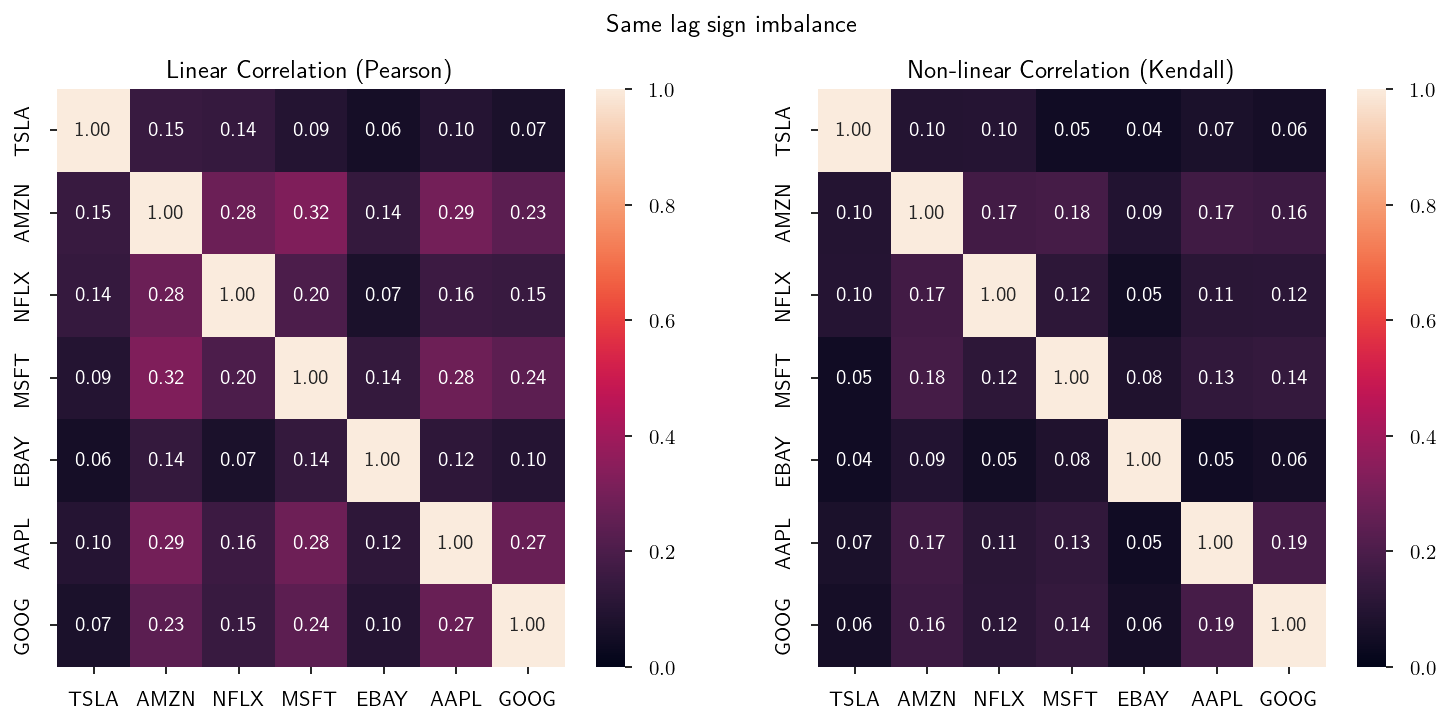

In [19]:
sign_imbalance_data = pd.concat([x["sign_imbalance"] for x in downsampled_data.values()], axis=1)
sign_imbalance_data = sign_imbalance_data.dropna()
sign_imbalance_data.columns = downsampled_data.keys()
display_corr(sign_imbalance_data,  "Same lag sign imbalance")

## Cross impact analysis
We examine how the average imbalance in order flow on a given asset impacts the price of other correlated assets.

### The univariate case

In [20]:
def _get_aggregate_impact(stock_df: pd.DataFrame, 
                          bin_sizes=list(range(1, 600)), 
                          units="s",
                          normalize = True,
                          conditional_variable="volume_imbalance") -> pd.DataFrame:
    """
    For a range of bin sizes specified in the input parameters computes
    downsampled time series of aggregate impact features and concatenates
    all results in a single Dataframe.
    
    NB depending on the sizes and frequency can take a very long time to run.
    (consider saving the result for re-using)
    """
    
    downsampled_impact_dfs = []
    for bin_size in bin_sizes:
        downsampled_data = downsample_tick_data(stock_df, bin_size=bin_size, unit=units)
        normalised_impact = aggregate_impact(downsampled_data, normalize=normalize, conditional_variable=conditional_variable)
        downsampled_impact_dfs.append(normalised_impact)
    return pd.concat(downsampled_impact_dfs, axis=0)

In [21]:
# The effect of bin-size and sign imbalance

LOAD_EXISTING = True  # change this flag to force impact re-computation

if LOAD_EXISTING:
    # load the data from pickle file instead of re-computing
    import pickle
    all_stock_data = pickle.load(open("all_stocks_agg_features.pkl", "rb"))
    
else:
    # compute aggregate impact for each stock and binning frequency
    all_stock_data = {}
    for stock_name, stock_df in stock_data.items():
        all_stock_data[stock_name] = _get_aggregate_impact(
            stock_df.copy(), bin_sizes=BINNING_FREQUENCIES, units="s", conditional_variable="sign_imbalance"
        )
        
    import pickle
    with open("all_stocks_agg_features.pkl", "wb") as f:
            pickle.dump(all_stock_data, f)

In [22]:
all_stock_data["TSLA"]

,T,sign_imbalance,R
0,10,0.000529,-1.354843
1,10,-0.000076,-5.018683
2,10,0.000000,-5.222688
3,10,-0.000529,-6.759821
4,10,0.000076,1.778821
...,...,...,...
52294,600,-0.007415,-15.607631
52295,600,-0.001445,-37.365874
52296,600,-0.012230,-8.928599
52297,600,-0.000482,44.211904


In [23]:
def combine_cross_orderflow(orderflow_imbalance: pd.DataFrame, 
                            price_response: pd.DataFrame, 
                            imbalance_column: str ="volume_imbalance") -> pd.DataFrame:
    """
    Helper function to combine aggregate features across lags between different instruments.
    For each lag the length is compared and longer series are truncated to ensure precise
    index alignment between timeseries of orderflow imbalance of one instrument with 
    price response observations for another instrument.
    
    Returns new DataFrame with features ready for model fitting.
    """
    
    bin_sizes = orderflow_imbalance["T"].unique()
    
    new_orderflow = []
    new_T = []
    new_price_response = []
    
    for bin_size in bin_sizes:
        orderflow_imbalance_ = orderflow_imbalance[orderflow_imbalance["T"] == bin_size][imbalance_column]
        T_ = orderflow_imbalance[orderflow_imbalance["T"] == bin_size]["T"]
        price_response_ = price_response[price_response["T"] == bin_size]["R"]
        
        
        if orderflow_imbalance_.shape[0] != len(price_response_):
            min_len = min(orderflow_imbalance_.shape[0], price_response_.shape[0])
            orderflow_imbalance_ = orderflow_imbalance_[:min_len]
            price_response_ = price_response_[:min_len]
            T_ = T_[:min_len]
            
        
        new_orderflow.extend(orderflow_imbalance_)
        new_T.extend(T_)
        new_price_response.extend(price_response_)
        
    new_df = pd.DataFrame({
        "R": new_price_response,
        imbalance_column: new_orderflow,
        "T": new_T,
    })
    
    return new_df.dropna()

In [24]:
# How AMZN and MSFT orderflow impacts respective prices
amzn_data = all_stock_data["AMZN"]
msft_data = all_stock_data["MSFT"]

#### orderflow(amzn_data) –> price(msft_data)

In [25]:
imbalance_column = "sign_imbalance"
orderflow_imbalance = amzn_data[["T","sign_imbalance"]].copy()
price_response = msft_data[["R", "T"]].copy()
amzn_msft_cross_impact = combine_cross_orderflow(orderflow_imbalance, price_response, "sign_imbalance")

In [26]:
# plot orderflow(amzn_data) –> price(msft_data)
fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = amzn_msft_cross_impact[amzn_msft_cross_impact['T']==T][["T", imbalance_column, "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=False)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, x_col=imbalance_column, y_col="R", q=31, duplicates="drop")

    T_values = binned_data['T'].values
    imbalance_values = binned_data[imbalance_column].values
    R_values = binned_data['R'].values

    params = fit_scaling_form(T_values, imbalance_values, R_values, reflect_y=False)
    fit_param[T] = params

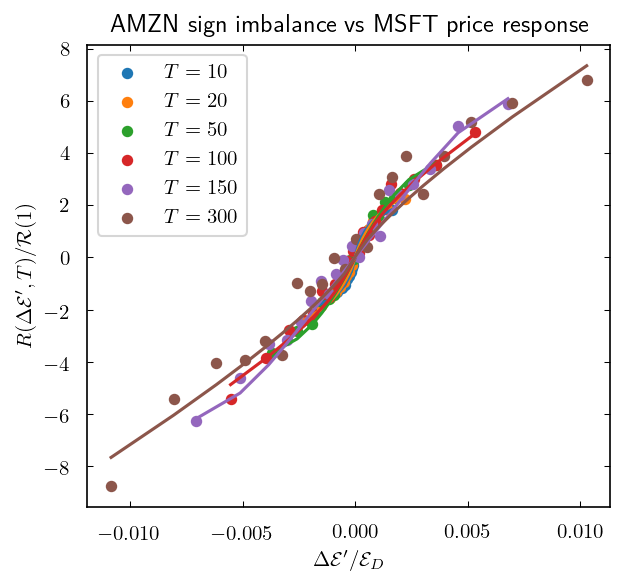

In [27]:
plot_scaling_form(amzn_msft_cross_impact, fit_parameters=fit_param, 
                  q=21, imbalance_column=imbalance_column, title="AMZN sign imbalance vs MSFT price response")

#### orderflow(msft_data) –> price(amzn_data)

In [28]:
orderflow_imbalance = msft_data[["T","sign_imbalance"]].copy()
price_response = amzn_data[["R", "T"]].copy()
msft_amzn_cross_impact = combine_cross_orderflow(orderflow_imbalance, price_response, "sign_imbalance")

In [29]:
# plot orderflow(msft_data) –> price(amzn_data)
fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = msft_amzn_cross_impact[msft_amzn_cross_impact['T']==T][["T", imbalance_column, "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=False)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, x_col=imbalance_column, y_col="R", q=31, duplicates="drop")

    T_values = binned_data['T'].values
    imbalance_values = binned_data[imbalance_column].values
    R_values = binned_data['R'].values

    params = fit_scaling_form(T_values, imbalance_values, R_values, reflect_y=False)
    fit_param[T] = params

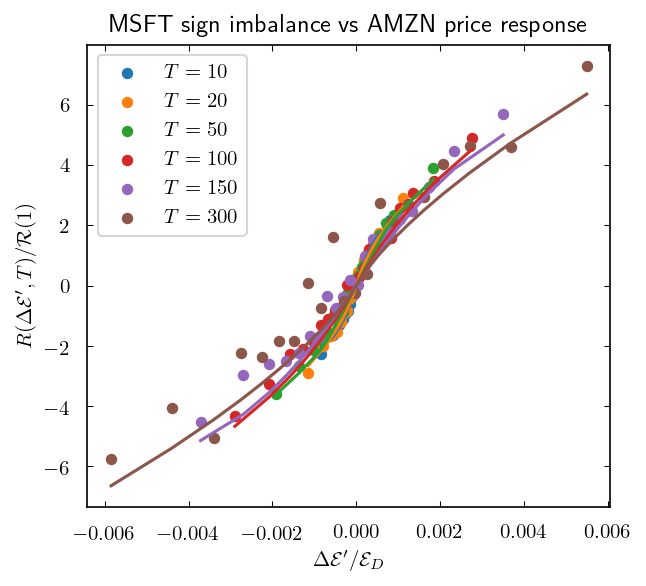

In [30]:
plot_scaling_form(msft_amzn_cross_impact, fit_parameters=fit_param, q=21, imbalance_column=imbalance_column, 
                  title="MSFT sign imbalance vs AMZN price response")

#### Finite size scaling analysis

#### orderflow(amzn_data) –> price(msft_data)

In [31]:
# Prepare the data for fitting
T_values = amzn_msft_cross_impact['T'].values
imbalance_values = amzn_msft_cross_impact[imbalance_column].values
R_values = amzn_msft_cross_impact['R'].values

# Fit data for all Ts
original_params = fit_scaling_law(T_values, imbalance_values, R_values, reflect_y=False)

In [32]:
# Retrieve optimized params
chi, kappa, alpha, beta, CONST = original_params
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.6729450343106942
kappa: 1.0533248106779478
alpha: 0.5334725863867105
beta: 82.55315419453864
CONST: 8343.950769224191


In [33]:
# Transform/ renormalize scaling parameters
rescaled_data = transform(amzn_msft_cross_impact, original_params, OBSERVATION_WINDOWS, reflect_y=False, imbalance_column=imbalance_column)

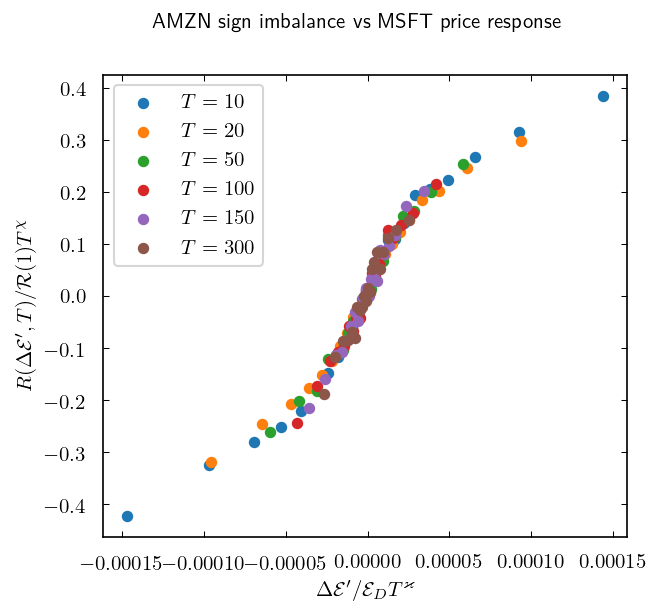

In [34]:
plot_scaling_law(rescaled_data=rescaled_data, q=21, imbalance_column=imbalance_column, predictions=False, 
                 title="AMZN sign imbalance vs MSFT price response")

In [35]:
amz_msft_new_data = rescaled_data[50].data[['sign_imbalance','R']].copy()
amz_msft_new_data

,sign_imbalance,R
51783468,0.000003,0.256908
51783469,0.000040,-0.834194
51783470,-0.000002,0.153408
51783471,-0.000011,-0.961820
51783472,-0.000074,-0.829771
...,...,...
52411051,-0.000005,0.090795
52411052,-0.000009,-0.316127
52411053,-0.000018,0.243110
52411054,0.000027,0.499326


In [36]:
# Dynamically bin data
binned_data = bin_data_into_quantiles(amz_msft_new_data, x_col=imbalance_column, y_col="R", q=20, duplicates="drop")

In [37]:
# Cross-impact correlation 
binned_data.corr(method='kendall')

,sign_imbalance,R
sign_imbalance,1.000000,0.978947
R,0.978947,1.000000


### The multivariate case 
We analyse how the average price change of stock $i$ given an imbalance in stock $j$ at time $t$ in the multivariate case, where the sign covariances are rescaled by $\tau$.

In [38]:
# Price response covariance matrix 

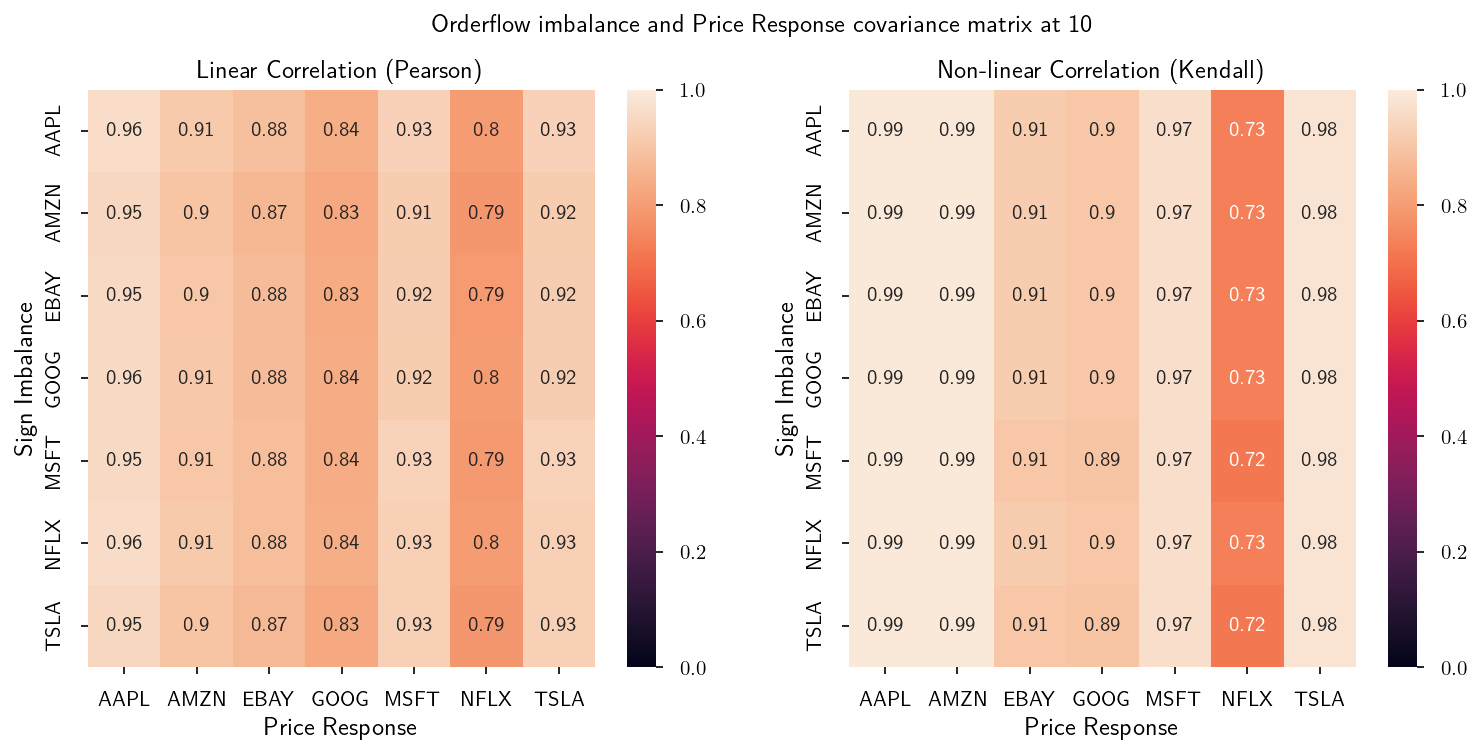

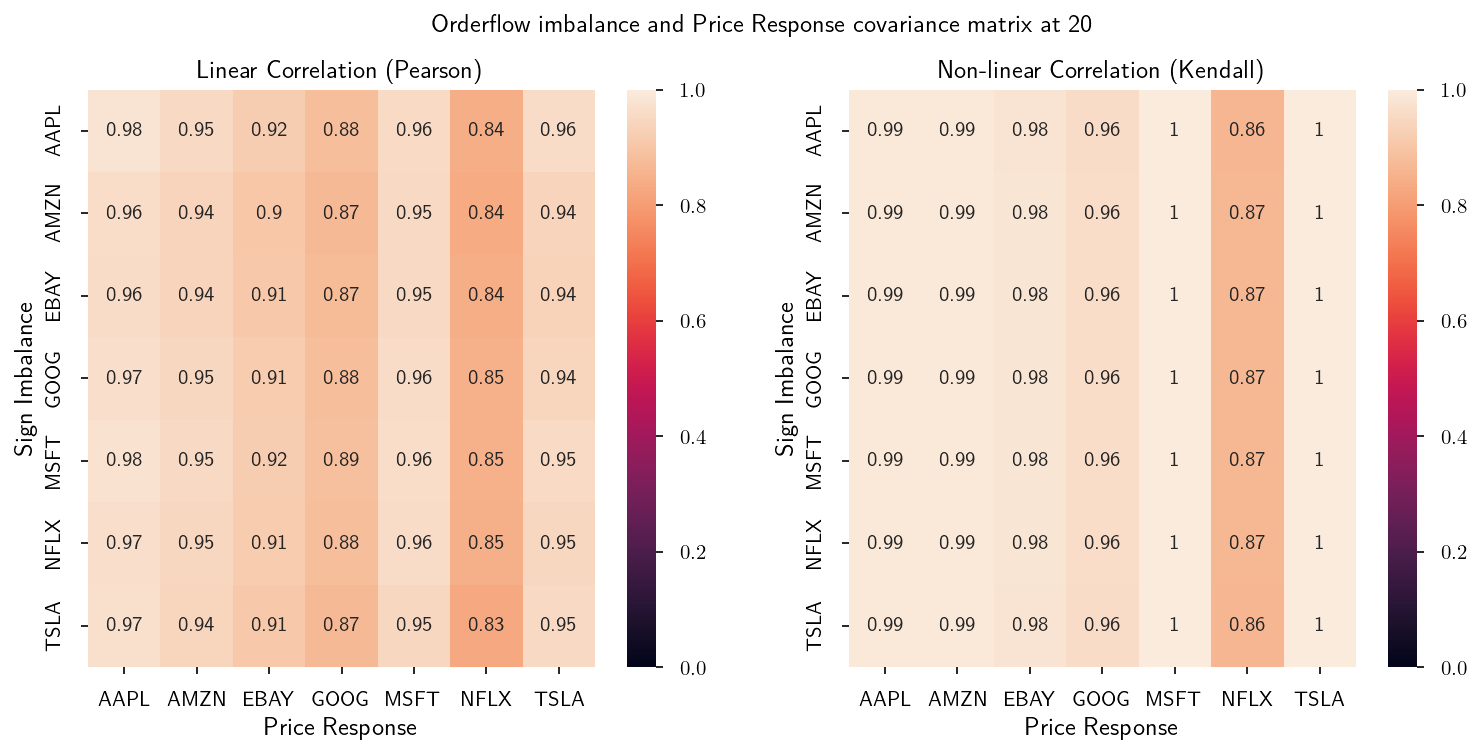

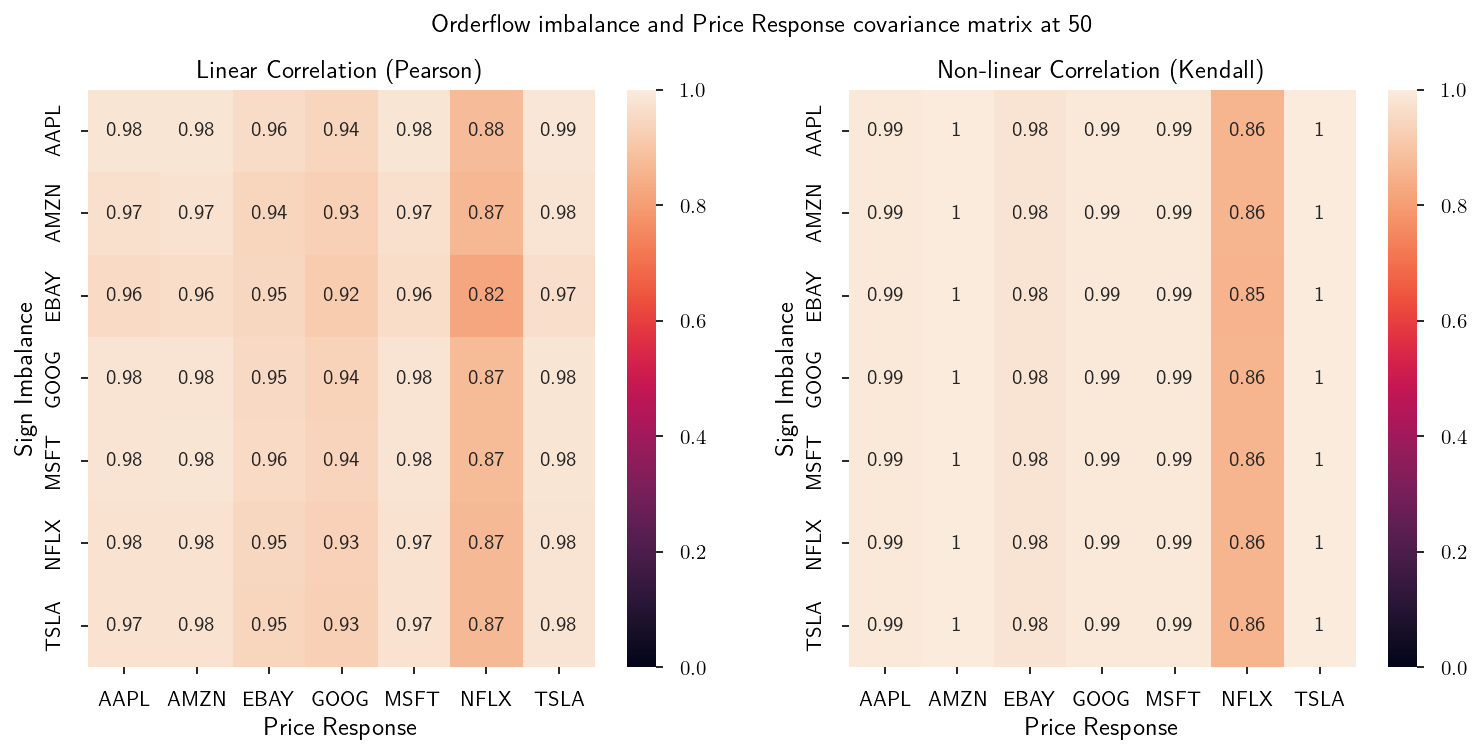

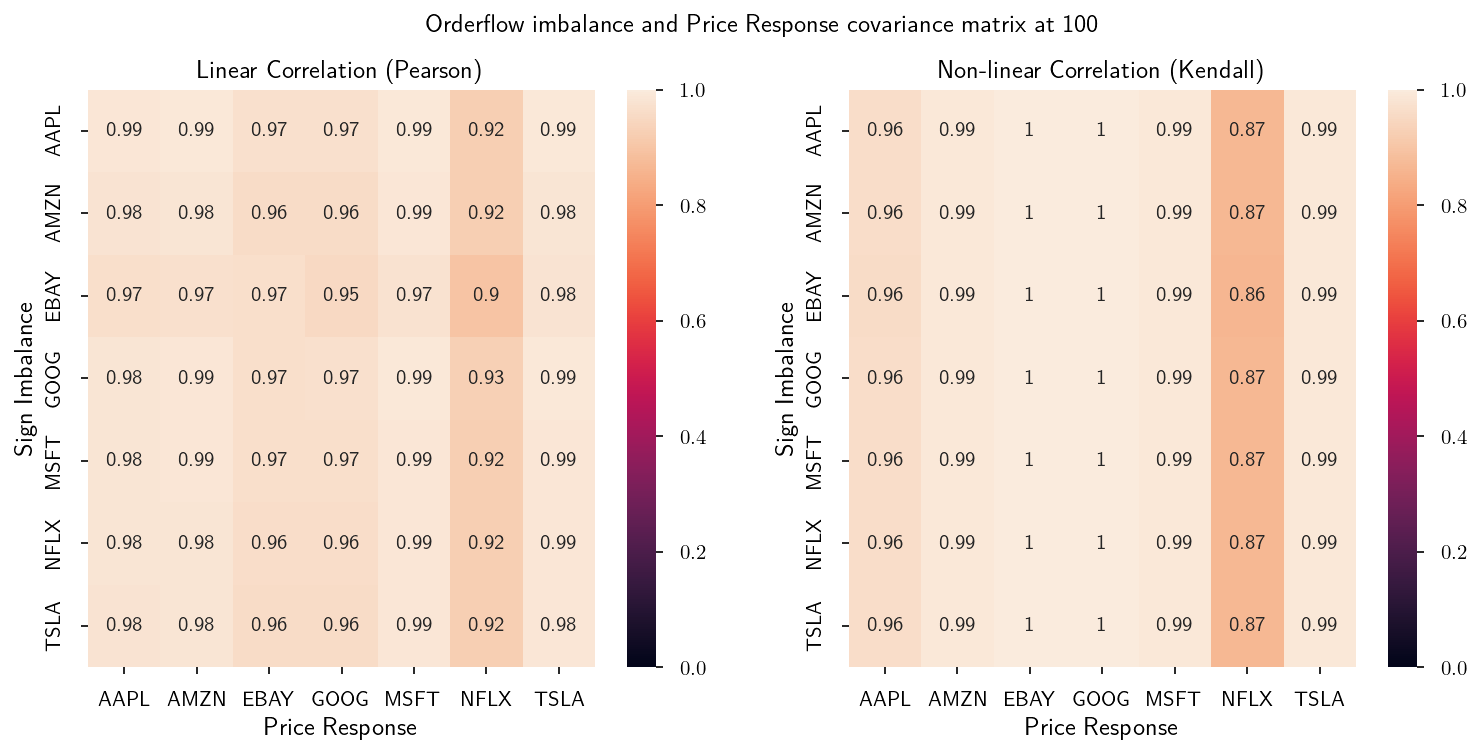

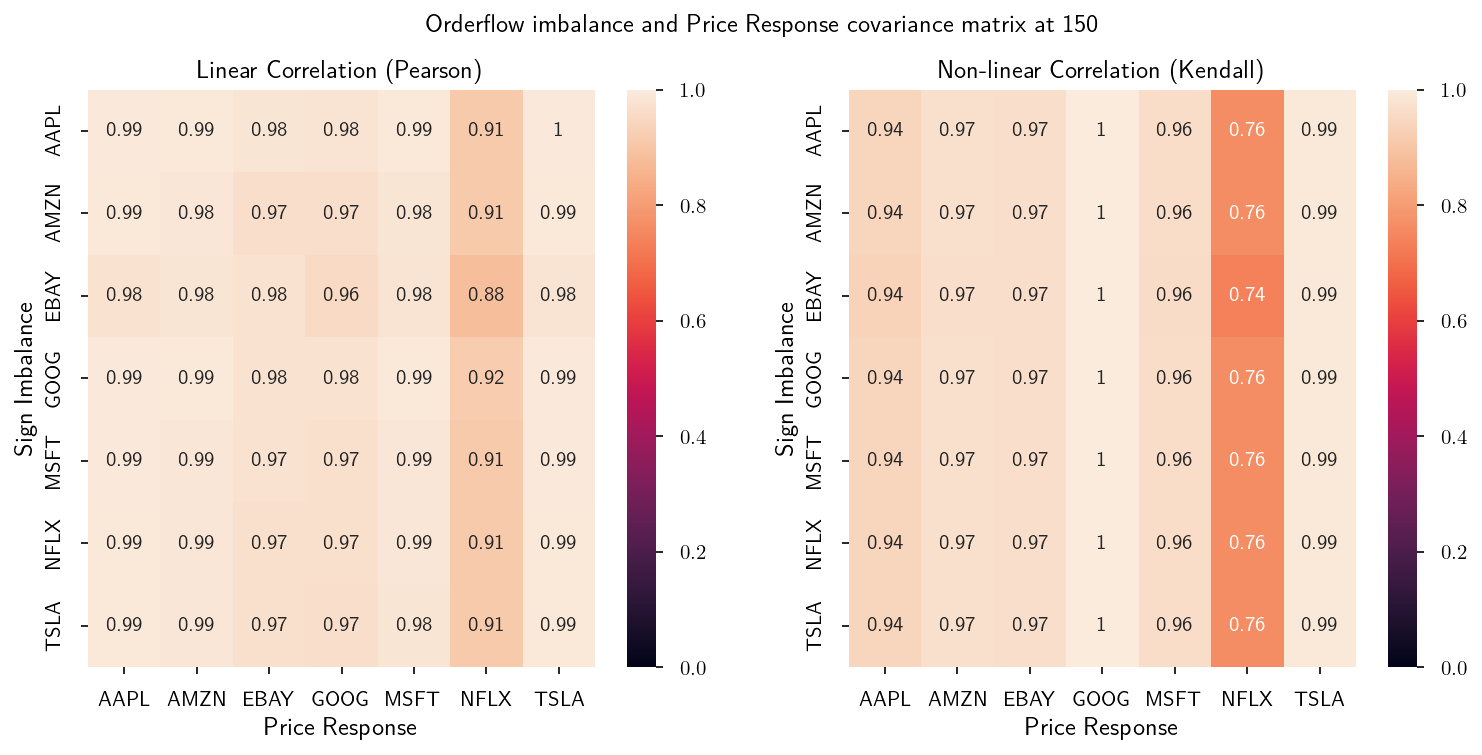

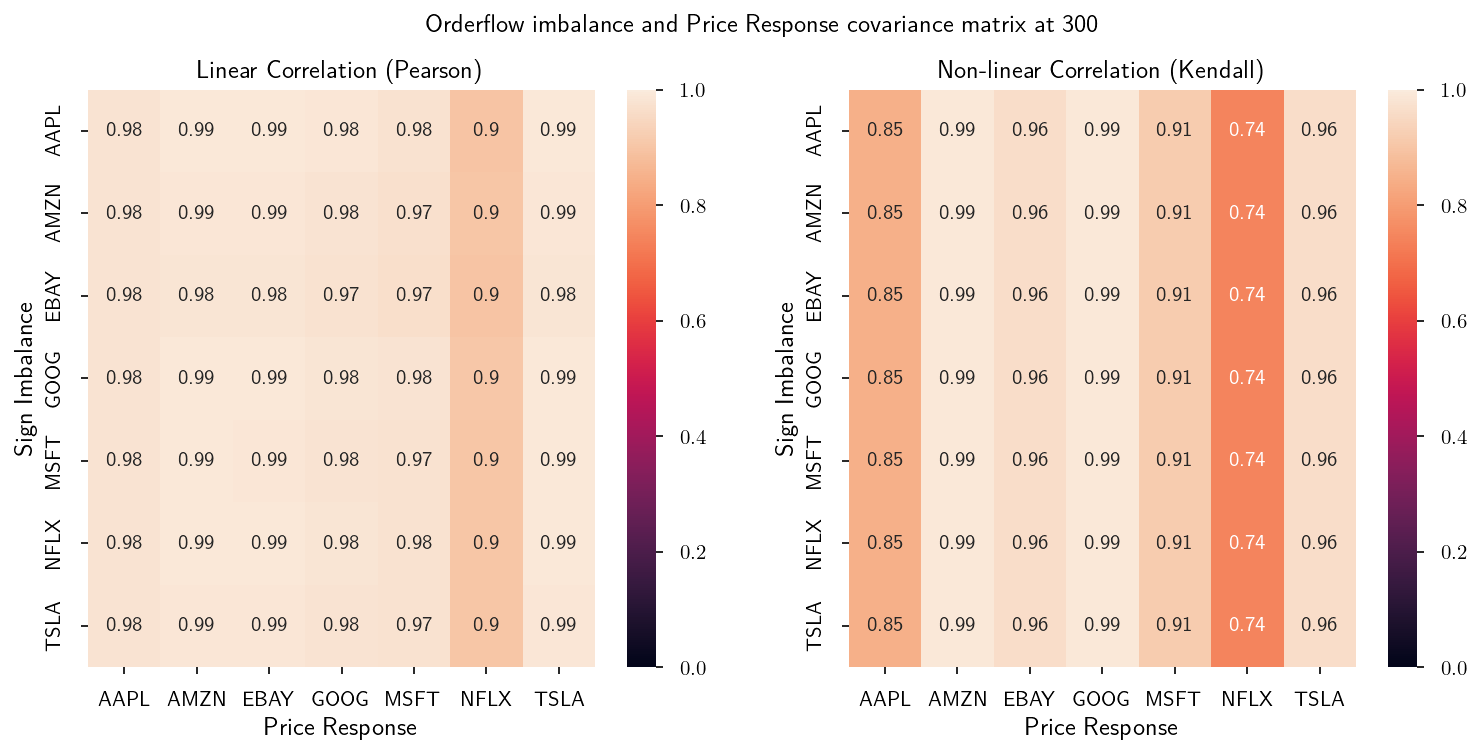

In [39]:
# all_stock_data - dictionary of stock name to it's aggregate features Dataframe for range of lags

for T in OBSERVATION_WINDOWS:

    imbalances = pd.DataFrame({
    stock_name: bin_data_into_quantiles(stock_data[stock_data["T"]==T], x_col=imbalance_column, y_col="R", q=21, duplicates="drop")[imbalance_column] 
                  for stock_name, stock_data in all_stock_data.items()})
    
    
    price_responses = pd.DataFrame({
    stock_name: bin_data_into_quantiles(stock_data[stock_data["T"]==T], x_col=imbalance_column, y_col="R", q=21, duplicates="drop")["R"] 
                  for stock_name, stock_data in all_stock_data.items()})
    
    
    
    display_crosscorrelation(imbalances, price_responses, 
                         x_label="Price Response", y_label="Sign Imbalance",
                         title=f"Orderflow imbalance and Price Response covariance matrix at {T}")